In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Requirement  
- `Final_Code_Data.csv` is the labeled data for training
- `GPT4_label_211Sample.csv` saved the result for GPT4 Chain-of-Thought (CoT) model

### Import Library

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from collections import Counter
from sklearn.metrics import confusion_matrix, accuracy_score
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_distances
from transformers import BertTokenizer, BertModel
from sklearn.decomposition import PCA

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on {}".format(device))

Running on cuda


### Read the Final Data

In [4]:
# Change this to the location of your data
# df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Info256/Final_Code_Data.csv')
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Info256 Project/Final_Code_Data.csv')

# Preprocessing to encode the technology labels
titles = df["title"].tolist()
descriptions = df["description"].tolist()
extract_tokens = df["512 tokens"].tolist()
labels = df["technology"].tolist()

## Majority Baseline

- Results:
  - **Training Accuracy: 36.19%**

In [5]:
# Map labels to numerical values
unique_labels = sorted(set(labels))
label_map = {label: i for i, label in enumerate(unique_labels)}
labels = [label_map[label] for label in labels]

label_counts = {}
for label, idx in label_map.items():
    count = labels.count(idx)
    label_counts[label] = count
    print(f"{label}: {count} samples")

# Calculate the proportion of the most common label
most_common_count = max(label_counts.values())
total_count = len(labels)
proportion_most_common = most_common_count / total_count

print(f"\nProportion of the most common label: {proportion_most_common:.4f}")

AI / ML: 50 samples
API: 10 samples
Cloud: 28 samples
Data: 49 samples
Non-PM: 231 samples
Other type of PM: 283 samples
Payments: 57 samples
Platform: 62 samples
Trust & Safety: 12 samples

Proportion of the most common label: 0.3619


## BERT for text classification

### Configuration:
- **BERT Settings**:
  - `batch_size = 16`
  - `max_length = 512` (maximum token length for each input)
  - `learning_rate = 2e-5`
  - `num_epochs = 7`
  - `best_val_model`

### BERT Model Set Up

In [6]:
class TextDataset(Dataset):
    """Custom Dataset for text classification with titles and descriptions"""
    def __init__(self, titles, descriptions, labels, tokenizer, max_length=512):
        self.titles = titles
        self.descriptions = descriptions
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.titles)

    def __getitem__(self, idx):
        title = str(self.titles[idx])
        description = str(self.descriptions[idx])
        text = f"{title} {description}"

        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'token_type_ids': encoding['token_type_ids'].squeeze(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

class BERTClassifier(nn.Module):
    def __init__(self, num_classes, model_name='bert-base-uncased', dropout=0.1):
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )

        # Get CLS token representation
        pooled_output = outputs.last_hidden_state[:, 0, :]
        pooled_output = self.dropout(pooled_output)
        logits = self.fc(pooled_output)
        return logits

def get_predictions(model, val_loader, device):
    """Get predictions from the model"""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask, token_type_ids)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

def plot_confusion_matrix(y_true, y_pred, label_map, method=None, figsize=(12, 8)):
    """Plot confusion matrix with custom labels"""
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    title = f'Confusion Matrix {method}' if method else 'Confusion Matrix'

    # Get unique labels present in the data
    present_labels = sorted(set(y_true))
    label_names = [list(label_map.keys())[i] for i in present_labels]

    # Create figure and axes
    plt.figure(figsize=figsize)

    # Create heatmap
    sns.heatmap(cm,
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=label_names,
                yticklabels=label_names)

    # Customize the plot
    plt.title(title, pad=20)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # Rotate labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    return plt

# Function to evaluate and plot confusion matrix
def evaluate_and_plot(model, val_loader, label_map, device):
    """Evaluate model and plot confusion matrix"""
    # Get predictions
    y_true, y_pred = get_predictions(model, val_loader, device)

    # Plot confusion matrix
    plot = plot_confusion_matrix(y_true, y_pred, label_map, method='BERT')
    plt.show()

    # Print classification report
    print("\nClassification Report:")
    present_labels = sorted(set(y_true))
    label_names = [list(label_map.keys())[i] for i in present_labels]
    print(classification_report(y_true, y_pred,
                              labels=present_labels,
                              target_names=label_names,
                              digits=3))

def train_bert_classifier(train_titles, train_descriptions, train_labels,
                         val_titles, val_descriptions, val_labels,
                         num_classes, batch_size=16, num_epochs=5,
                         learning_rate=2e-5, max_length=512,
                         model_name='bert-base-uncased'):
    """
    Train BERT classifier end-to-end
    """
    # Initialize tokenizer
    tokenizer = BertTokenizer.from_pretrained(model_name)

    # Create datasets
    train_dataset = TextDataset(train_titles, train_descriptions, train_labels,
                               tokenizer, max_length)
    val_dataset = TextDataset(val_titles, val_descriptions, val_labels,
                             tokenizer, max_length)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = BERTClassifier(num_classes=num_classes, model_name=model_name)
    model.to(device)

    # Initialize optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # Training loop
    best_val_acc = 0
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        # Training
        for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask, token_type_ids)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                token_type_ids = batch['token_type_ids'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids, attention_mask, token_type_ids)
                # Calculate loss
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        train_acc = train_correct / train_total
        val_acc = val_correct / val_total

        print(f'Epoch {epoch + 1}:')
        print(f'Train Loss: {train_loss/len(train_loader):.4f}')
        print(f'Train Accuracy: {train_acc:.4f}')
        print(f'Validation Loss: {val_loss/len(val_loader):.4f}')
        print(f'Validation Accuracy: {val_acc:.4f}')

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_bert_classifier.pt')

    # Load best model and evaluate
    model.load_state_dict(torch.load('best_bert_classifier.pt'))
    print("\nEvaluating best model:")
    evaluate_and_plot(model, val_loader, label_map, device)

    return model

### Sample Misclassfication Method

In [11]:
def display_misclassifications(model, val_titles, val_descriptions, val_labels,
                             label_map, batch_size=16, max_length=512,
                             model_name='bert-base-uncased', num_examples=3):
    """
    Display detailed misclassification examples from the BERT model predictions

    Args:
        model: Trained BERT model
        val_titles: List of validation titles
        val_descriptions: List of validation descriptions
        val_labels: List of validation labels
        label_map: Dictionary mapping label names to indices
        batch_size: Batch size for validation (default=16)
        max_length: Maximum sequence length (default=512)
        model_name: Name of the BERT model (default='bert-base-uncased')
        num_examples: Number of misclassification examples to show (default=10)
    """
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Initialize tokenizer
    tokenizer = BertTokenizer.from_pretrained(model_name)

    # Create validation dataset
    val_dataset = TextDataset(val_titles, val_descriptions, val_labels,
                             tokenizer, max_length)

    # Create validation dataloader
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Get reverse label map for converting indices to label names
    rev_label_map = {i: label for label, i in label_map.items()}

    model.eval()
    misclassifications = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['labels'].to(device)

            # Get original texts
            original_texts = []
            for i in range(len(input_ids)):
                title = val_titles[i]
                desc = val_descriptions[i]
                original_texts.append(f"{title} {desc}")

            outputs = model(input_ids, attention_mask, token_type_ids)
            _, predicted = torch.max(outputs, 1)

            # Find misclassifications in this batch
            for text, pred, true_label in zip(original_texts, predicted, labels):
                if pred != true_label:
                    misclassifications.append({
                        'text': text,
                        'predicted': rev_label_map[pred.item()],
                        'actual': rev_label_map[true_label.item()]
                    })

    # Print misclassification examples
    print("\n=== BERT Model Misclassifications ===\n")

    for i, misc in enumerate(misclassifications[:num_examples], 1):
        print(f"Example {i}:")
        print(f"Predicted: {misc['predicted']}")
        print(f"Actual: {misc['actual']}")
        print(f"Title + Description: {misc['text']}")
        print("-" * 50 + "\n")

    # Print summary statistics
    total_misclassifications = len(misclassifications)
    print(f"\nTotal misclassifications found: {total_misclassifications}")

    # Group misclassifications by actual vs predicted
    confusion_pairs = Counter(
        (misc['actual'], misc['predicted'])
        for misc in misclassifications
    )

    print("\nMost common misclassification patterns:")
    for (actual, predicted), count in confusion_pairs.most_common(5):
        print(f"{actual} → {predicted}: {count} instances")


### Confidence Interval Method

In [12]:
def create_validation_loader(val_titles, val_descriptions, val_labels, tokenizer, batch_size=16, max_length=512):
    """
    Create validation DataLoader from raw validation data
    """
    val_dataset = TextDataset(val_titles, val_descriptions, val_labels,
                             tokenizer, max_length)
    return DataLoader(val_dataset, batch_size=batch_size)

def bootstrap_confidence_interval(model, val_titles, val_descriptions, val_labels, device,
                                model_name='bert-base-uncased', n_iterations=1000,
                                confidence_level=0.95, batch_size=16):
    """
    Calculate confidence interval for model accuracy using bootstrap sampling.
    """
    # Initialize tokenizer
    tokenizer = BertTokenizer.from_pretrained(model_name)

    # Create validation loader with all data
    val_loader = create_validation_loader(val_titles, val_descriptions, val_labels,
                                        tokenizer, batch_size)

    # Get all predictions and true labels
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask, token_type_ids)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Calculate original accuracy
    original_accuracy = accuracy_score(all_labels, all_preds)

    # Perform bootstrap sampling
    bootstrap_accuracies = []
    n_samples = len(all_labels)

    for _ in tqdm(range(n_iterations), desc="Bootstrap Sampling"):
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        sample_true = all_labels[indices]
        sample_pred = all_preds[indices]
        accuracy = accuracy_score(sample_true, sample_pred)
        bootstrap_accuracies.append(accuracy)

    # Calculate confidence interval
    alpha = 1 - confidence_level
    lower_percentile = alpha / 2 * 100
    upper_percentile = (1 - alpha / 2) * 100

    lower_bound = np.percentile(bootstrap_accuracies, lower_percentile)
    upper_bound = np.percentile(bootstrap_accuracies, upper_percentile)

    return original_accuracy, lower_bound, upper_bound, bootstrap_accuracies

def plot_bootstrap_distribution(bootstrap_accuracies, original_accuracy, lower_bound, upper_bound):
    """
    Plot the distribution of bootstrap accuracy samples with confidence interval.
    """
    plt.figure(figsize=(10, 6))
    plt.hist(bootstrap_accuracies, bins=50, density=True, alpha=0.7, color='skyblue')
    plt.axvline(original_accuracy, color='red', linestyle='--', label='Original Accuracy')
    plt.axvline(lower_bound, color='green', linestyle='--', label='Lower Bound')
    plt.axvline(upper_bound, color='green', linestyle='--', label='Upper Bound')

    plt.title('Bootstrap Distribution of Accuracy')
    plt.xlabel('Accuracy')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.show()

def analyze_model_confidence(model, val_titles, val_descriptions, val_labels, device,
                           n_iterations=1000, confidence_level=0.95, batch_size=16):
    """
    Perform complete confidence interval analysis for the model.
    """
    print(f"\nPerforming bootstrap analysis with {n_iterations} iterations...")

    # Get confidence interval and bootstrap accuracies
    original_accuracy, lower_bound, upper_bound, bootstrap_accuracies = bootstrap_confidence_interval(
        model=model,
        val_titles=val_titles,
        val_descriptions=val_descriptions,
        val_labels=val_labels,
        device=device,
        n_iterations=n_iterations,
        confidence_level=confidence_level,
        batch_size=batch_size
    )

    # Print results
    print(f"\nConfidence Interval Analysis Results ({confidence_level*100}% CI):")
    print(f"Original Accuracy: {original_accuracy:.4f}")
    print(f"Confidence Interval: [{lower_bound:.4f}, {upper_bound:.4f}]")
    print(f"Interval Width: {upper_bound - lower_bound:.4f}")

    # Plot the distribution
    plot_bootstrap_distribution(bootstrap_accuracies, original_accuracy, lower_bound, upper_bound)

    return original_accuracy, lower_bound, upper_bound, bootstrap_accuracies

### Model 1 - BERT with Whole Job Description (Truncated)

- Results:
  - Training Accuracy: 85.81%
  - Dev Accuracy: 61.78%
  - 95% Confidence Interval: `[0.5478, 0.6881]`

In [7]:
# Split the data into 80% train and 20% validation sets
X_train_BERT, X_val_BERT, y_train_BERT, y_val_BERT = train_test_split(
    list(zip(titles, descriptions)), labels,
    test_size=0.2,
    random_state=256,
    stratify=labels  # Ensure balanced split
)

# Unzip the training and validation data
train_titles, train_descriptions = zip(*X_train_BERT)
val_titles, val_descriptions = zip(*X_val_BERT)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1/7: 100%|██████████| 40/40 [00:26<00:00,  1.50it/s]


Epoch 1:
Train Loss: 1.7502
Train Accuracy: 0.3280
Validation Loss: 1.6400
Validation Accuracy: 0.4013


Epoch 2/7: 100%|██████████| 40/40 [00:24<00:00,  1.62it/s]


Epoch 2:
Train Loss: 1.5570
Train Accuracy: 0.4400
Validation Loss: 1.4242
Validation Accuracy: 0.4968


Epoch 3/7: 100%|██████████| 40/40 [00:24<00:00,  1.63it/s]


Epoch 3:
Train Loss: 1.1779
Train Accuracy: 0.6144
Validation Loss: 1.2195
Validation Accuracy: 0.5796


Epoch 4/7: 100%|██████████| 40/40 [00:24<00:00,  1.63it/s]


Epoch 4:
Train Loss: 0.8581
Train Accuracy: 0.7296
Validation Loss: 1.1952
Validation Accuracy: 0.6178


Epoch 5/7: 100%|██████████| 40/40 [00:24<00:00,  1.63it/s]


Epoch 5:
Train Loss: 0.6052
Train Accuracy: 0.8144
Validation Loss: 1.2881
Validation Accuracy: 0.5732


Epoch 6/7: 100%|██████████| 40/40 [00:24<00:00,  1.63it/s]


Epoch 6:
Train Loss: 0.4325
Train Accuracy: 0.8688
Validation Loss: 1.3299
Validation Accuracy: 0.5924


Epoch 7/7: 100%|██████████| 40/40 [00:24<00:00,  1.63it/s]


Epoch 7:
Train Loss: 0.2610
Train Accuracy: 0.9248
Validation Loss: 1.4523
Validation Accuracy: 0.5860


<ipython-input-6-c38eeb8c4277>:221: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_bert_classifier.pt'))



Evaluating best model:


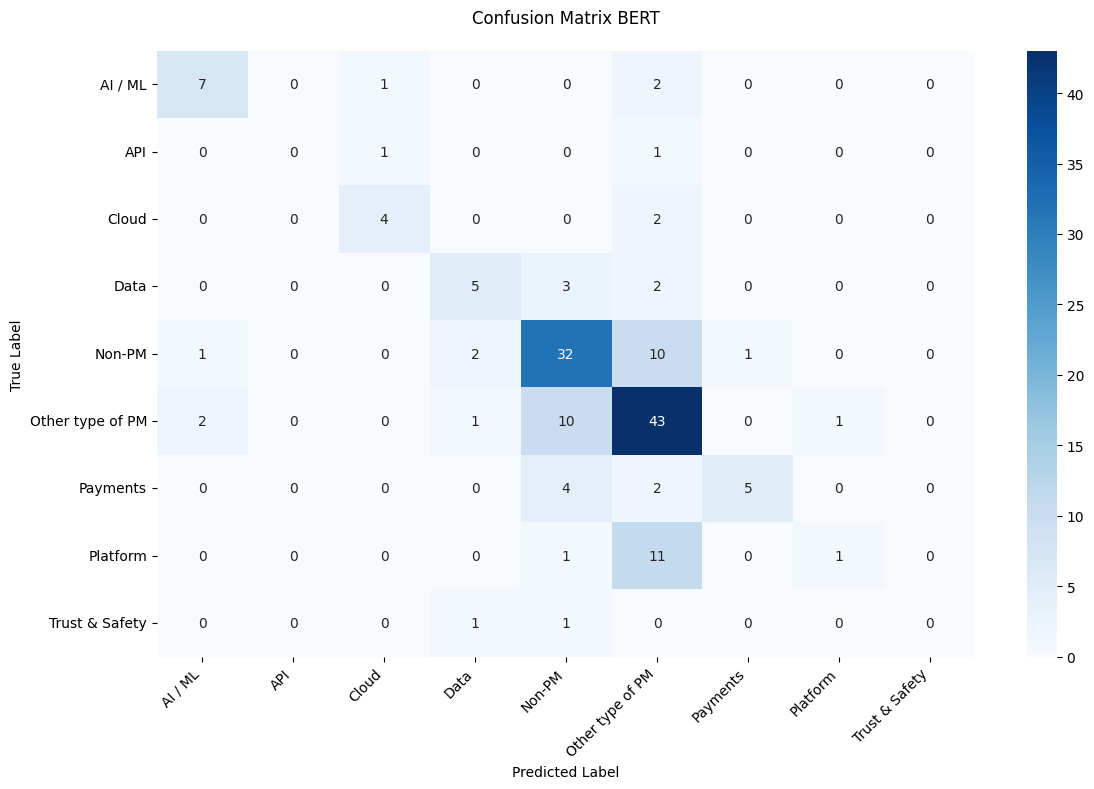


Classification Report:
                  precision    recall  f1-score   support

         AI / ML      0.700     0.700     0.700        10
             API      0.000     0.000     0.000         2
           Cloud      0.667     0.667     0.667         6
            Data      0.556     0.500     0.526        10
          Non-PM      0.627     0.696     0.660        46
Other type of PM      0.589     0.754     0.662        57
        Payments      0.833     0.455     0.588        11
        Platform      0.500     0.077     0.133        13
  Trust & Safety      0.000     0.000     0.000         2

        accuracy                          0.618       157
       macro avg      0.497     0.428     0.437       157
    weighted avg      0.603     0.618     0.589       157



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [8]:
# Assuming you have your data split into train and validation sets
num_classes = len(set(labels))  # Number of unique labels

model = train_bert_classifier(
    train_titles=train_titles,
    train_descriptions=train_descriptions,
    train_labels=y_train_BERT,
    val_titles=val_titles,
    val_descriptions=val_descriptions,
    val_labels=y_val_BERT,
    num_classes=num_classes,
    batch_size=16,  # Adjust based on your GPU memory
    num_epochs=7,
    learning_rate=2e-5,
    max_length=512
)

### Model 1 - Results Analysis

In [13]:
# Assuming you have your model and validation data ready
display_misclassifications(
    model=model,
    val_titles=val_titles,
    val_descriptions=val_descriptions,
    val_labels=y_val_BERT,
    label_map=label_map
)


=== BERT Model Misclassifications ===

Example 1:
Predicted: Non-PM
Actual: Other type of PM
Title + Description: Product Manager (Audio Visual - AV) **Primarily Roles & Responsibilities**

* Act as the product evangelist, constantly identifying opportunities via Voice-of-Customer and internal feedback from our sales team to improve the AV portfolio’s performance in support of our business strategy, including new products, product line extensions, product revisions, product retirements, pricing changes, product positioning changes, and marketing/sales programs.
* Track and analyze the product portfolio’s performance and profitability versus the targets, inform key stakeholders, and identify actions needed to meet the goals. Create quarterly sales and profitability forecasts for the portfolio.
* Research, analyze and monitor the market for customer application needs, market trends, competitive threats and growth opportunities. Develops and manages the execution of a product roadmap.
* 


Performing bootstrap analysis with 1000 iterations...


Bootstrap Sampling: 100%|██████████| 1000/1000 [00:00<00:00, 2270.11it/s]



Confidence Interval Analysis Results (95.0% CI):
Original Accuracy: 0.6178
Confidence Interval: [0.5478, 0.6881]
Interval Width: 0.1403


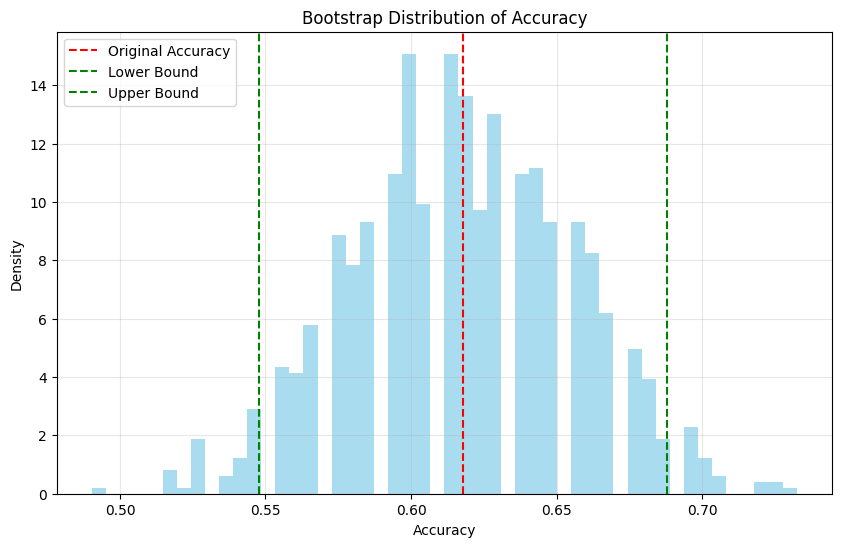

In [14]:
# After training your model
original_acc_1, lower_bound_1, upper_bound_1, bootstrap_accuracies_1 = analyze_model_confidence(
    model=model,
    val_titles=val_titles,
    val_descriptions=val_descriptions,
    val_labels=y_val_BERT,
    device=device,
    n_iterations=1000,
    confidence_level=0.95,
    batch_size=16
)

### Model 2 - BERT with 512 Extract Tokens
- Results:
  - Training Accuracy: 89.92%
  - Dev Accuracy: 64.97%
  - 95% Confidence Interval: `[0.5732, 0.7197]`

In [9]:
# Use the 512 tokens extracted
X_train_BERT_512, X_val_BERT_512, y_train_BERT_512, y_val_BERT_512 = train_test_split(
    list(zip(titles, extract_tokens)),  # Using title and '512 tokens' columns
    labels,
    test_size=0.2,
    random_state=256,
    stratify=labels
)
# Unzip the training and validation data
train_titles_512, train_descriptions_512 = zip(*X_train_BERT_512)
val_titles_512, val_descriptions_512 = zip(*X_val_BERT_512)

Epoch 1/7: 100%|██████████| 40/40 [00:18<00:00,  2.14it/s]


Epoch 1:
Train Loss: 1.7101
Train Accuracy: 0.3744
Validation Loss: 1.6128
Validation Accuracy: 0.4204


Epoch 2/7: 100%|██████████| 40/40 [00:18<00:00,  2.14it/s]


Epoch 2:
Train Loss: 1.5403
Train Accuracy: 0.4352
Validation Loss: 1.5251
Validation Accuracy: 0.4459


Epoch 3/7: 100%|██████████| 40/40 [00:18<00:00,  2.14it/s]


Epoch 3:
Train Loss: 1.3024
Train Accuracy: 0.5520
Validation Loss: 1.2854
Validation Accuracy: 0.5860


Epoch 4/7: 100%|██████████| 40/40 [00:18<00:00,  2.14it/s]


Epoch 4:
Train Loss: 0.9659
Train Accuracy: 0.6752
Validation Loss: 1.2866
Validation Accuracy: 0.6178


Epoch 5/7: 100%|██████████| 40/40 [00:18<00:00,  2.14it/s]


Epoch 5:
Train Loss: 0.7502
Train Accuracy: 0.7792
Validation Loss: 1.3320
Validation Accuracy: 0.5924


Epoch 6/7: 100%|██████████| 40/40 [00:18<00:00,  2.15it/s]


Epoch 6:
Train Loss: 0.5485
Train Accuracy: 0.8336
Validation Loss: 1.3011
Validation Accuracy: 0.6369


Epoch 7/7: 100%|██████████| 40/40 [00:18<00:00,  2.15it/s]


Epoch 7:
Train Loss: 0.3586
Train Accuracy: 0.8992
Validation Loss: 1.3479
Validation Accuracy: 0.6497


<ipython-input-6-c38eeb8c4277>:221: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_bert_classifier.pt'))



Evaluating best model:


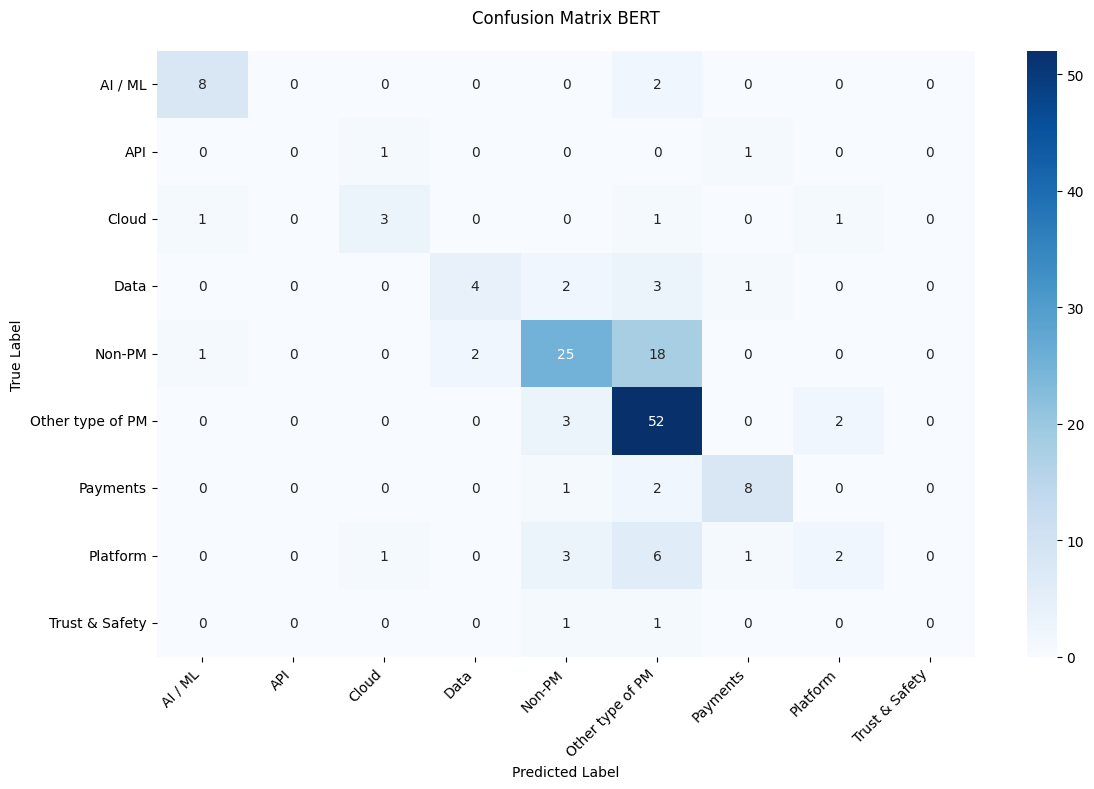


Classification Report:
                  precision    recall  f1-score   support

         AI / ML      0.800     0.800     0.800        10
             API      0.000     0.000     0.000         2
           Cloud      0.600     0.500     0.545         6
            Data      0.667     0.400     0.500        10
          Non-PM      0.714     0.543     0.617        46
Other type of PM      0.612     0.912     0.732        57
        Payments      0.727     0.727     0.727        11
        Platform      0.400     0.154     0.222        13
  Trust & Safety      0.000     0.000     0.000         2

        accuracy                          0.650       157
       macro avg      0.502     0.449     0.461       157
    weighted avg      0.632     0.650     0.620       157



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [10]:
# Assuming you have your data split into train and validation sets
num_classes = len(set(labels))  # Number of unique labels

model_512 = train_bert_classifier(
    train_titles=train_titles_512,
    train_descriptions=train_descriptions_512,
    train_labels=y_train_BERT_512,
    val_titles=val_titles_512,
    val_descriptions=val_descriptions_512,
    val_labels=y_val_BERT_512,
    num_classes=num_classes,
    batch_size=16,  # Adjust based on your GPU memory
    num_epochs=7,
    learning_rate=2e-5,
    max_length=512
)

### Model 2 - Results Analysis


Performing bootstrap analysis with 1000 iterations...


Bootstrap Sampling: 100%|██████████| 1000/1000 [00:00<00:00, 2249.87it/s]



Confidence Interval Analysis Results (95.0% CI):
Original Accuracy: 0.6497
Confidence Interval: [0.5732, 0.7197]
Interval Width: 0.1465


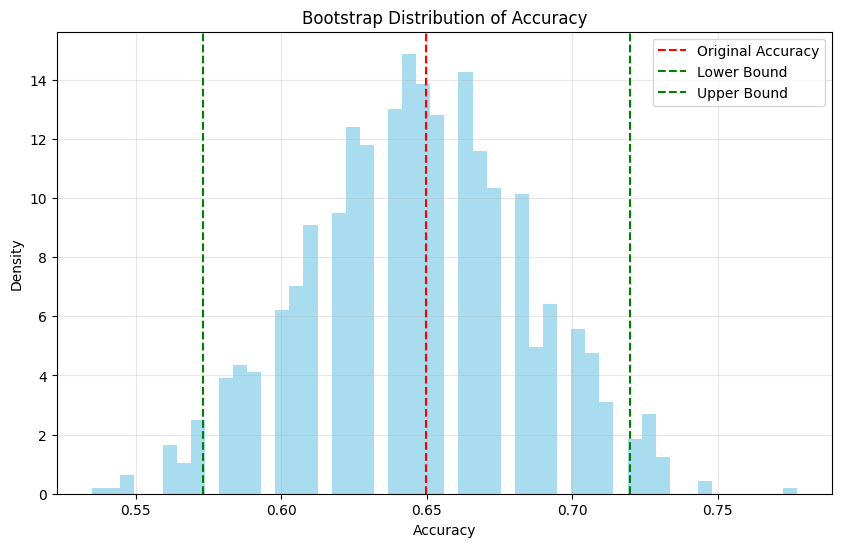

In [15]:
# After training your model
original_acc, lower_bound, upper_bound, bootstrap_accuracies = analyze_model_confidence(
    model=model_512,
    val_titles=val_titles_512,
    val_descriptions=val_descriptions_512,
    val_labels=y_val_BERT_512,
    device=device,
    n_iterations=1000,
    confidence_level=0.95,
    batch_size=16
)

In [16]:
# Assuming you have your model and validation data ready
display_misclassifications(
    model=model_512,
    val_titles=val_titles_512,
    val_descriptions=val_descriptions_512,
    val_labels=y_val_BERT_512,
    label_map=label_map
)


=== BERT Model Misclassifications ===

Example 1:
Predicted: Other type of PM
Actual: Data
Title + Description: BI Product, Product Management, Manager, Specialty the opportunity within the product team at travelers you will have the opportunity to regularly engage in unique and intellectually stimulating business problems as a manager product management you will manage the growth and profitability for a state s product or line of business you will analyze complex business problems and propose fact based solutions with consideration of internal and external trends to achieve business objectives by collaborating and influencing key stakeholders across the organization you will also ensure strategic direction and alignment for successful execution you will coach and lead cross functional team s on growth strategies products and objectives what will you do lead and guide the data analysis of business results including product refreshes performance expectations and identifying root cause 

## TF-IDF Classifier with Logistic Regression

### Configuration:
- **TF-IDF Vectorizer Settings**:
  - `max_features = 1000` (top 1000 features)
  - `ngram_range = (1, 2)` (unigrams and bigrams)
  - `stop_words = 'english'` (removes common English stop words)
  - `min_df = 2` (features must appear in at least 2 documents)
  - `max_df = 0.9` (features appear in at most 90% of documents)

- **Logistic Regression Settings**:
  - Regularization parameter: `C = 1` (default value)
  - Maximum iterations: `max_iter = 500` (for convergence)

### Results:
- **Training Accuracy**: 71.36%
- **Validation Accuracy: 52.23%**
- **95% Confidence Interval: `[0.4459, 0.5987]`**




In [17]:
# Combine title and description for TFIDF vectorizer
texts = [f"{title} {desc}" for title, desc in zip(titles, descriptions)]

# Train and validation sets split
X_train_tfidf, X_val_tfidf, y_train_tfidf, y_val_tfidf = train_test_split(
    texts, labels,
    test_size=0.2,
    random_state=256,
    stratify=labels  # Ensure balanced split
)

# Initialize and fit TF-IDF vectorizer
tfidf = TfidfVectorizer(
    max_features=768,  # Match BERT's dimension
    ngram_range=(1, 2), # unigrams and bigrams
    stop_words='english',
    min_df=2, # Appear in at least 2 documents
    max_df=0.9 # Appear in at most 90% of documents
)

# Texts to TF-IDF features
X_train_tfidf = tfidf.fit_transform(X_train_tfidf)
X_val_tfidf = tfidf.transform(X_val_tfidf)

# C = 1 default
print("\nTraining logistic regression classifier...")
clf = LogisticRegression(C=1, max_iter=500, random_state=256)
clf.fit(X_train_tfidf, y_train_tfidf)

# Print evaluation metrics
train_score = clf.score(X_train_tfidf, y_train_tfidf)
val_score = clf.score(X_val_tfidf, y_val_tfidf)
print(f"Train accuracy: {train_score:.4f}")

print(f"Validation accuracy: {val_score:.4f}")

# Print detailed evaluation
y_pred_tfidf = clf.predict(X_val_tfidf)
print("\nClassification Report:")

# Get unique labels present in the validation set
present_labels = sorted(set(y_val_tfidf))
label_names = [list(label_map.keys())[i] for i in present_labels]

print(classification_report(y_val_tfidf, y_pred_tfidf,
                          labels=present_labels,
                          target_names=label_names,
                          digits=3))

# Get top features for each class
def print_top_features(classifier, vectorizer, class_labels, n=10):
    """Print top features (words) for each class"""
    feature_names = np.array(vectorizer.get_feature_names_out())

    print("\nTop features per class:")
    for i, class_label in enumerate(class_labels):
        top_indices = np.argsort(classifier.coef_[i])[-n:]
        top_features = feature_names[top_indices]
        print(f"\n{class_label}:")
        print(", ".join(top_features))

print_top_features(clf, tfidf, list(label_map.keys()))

def predict_technology_tfidf(title, description):
    """Predict seniority level for a new job posting"""
    # Combine title and description
    text = f"{title} {description}"

    # Transform text using TF-IDF
    features = tfidf.transform([text])

    # Get prediction
    prediction = clf.predict(features)[0]
    probabilities = clf.predict_proba(features)[0]

    # Get original label
    predicted_label = list(label_map.keys())[list(label_map.values()).index(prediction)]

    # Get confidence scores
    confidence_scores = {list(label_map.keys())[i]: prob
                        for i, prob in enumerate(probabilities)}

    return predicted_label, confidence_scores


Training logistic regression classifier...
Train accuracy: 0.7136
Validation accuracy: 0.5223

Classification Report:
                  precision    recall  f1-score   support

         AI / ML      1.000     0.400     0.571        10
             API      0.000     0.000     0.000         2
           Cloud      0.500     0.167     0.250         6
            Data      1.000     0.100     0.182        10
          Non-PM      0.577     0.652     0.612        46
Other type of PM      0.478     0.772     0.591        57
        Payments      0.400     0.182     0.250        11
        Platform      0.000     0.000     0.000        13
  Trust & Safety      0.000     0.000     0.000         2

        accuracy                          0.522       157
       macro avg      0.439     0.253     0.273       157
    weighted avg      0.517     0.522     0.469       157


Top features per class:

AI / ML:
technologies, talent, systems, content, consumer, platform, experiences, world, learning,

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Model 3 - Confidence Interval

In [18]:
def bootstrap_confidence_interval_tfidf(clf, X_val, y_val, n_iterations=1000, confidence_level=0.95):
    """
    Calculate confidence interval for TFIDF model accuracy using bootstrap sampling.

    Args:
        clf: Trained logistic regression classifier
        X_val: Validation features (TFIDF matrix)
        y_val: Validation labels
        n_iterations: Number of bootstrap iterations
        confidence_level: Confidence level for the interval

    Returns:
        tuple: (original_accuracy, lower_bound, upper_bound, bootstrap_accuracies)
    """
    # Convert sparse matrix to dense if needed
    if hasattr(X_val, 'toarray'):
        X_val = X_val.toarray()

    # Get original predictions and accuracy
    y_pred = clf.predict(X_val)
    original_accuracy = accuracy_score(y_val, y_pred)

    # Perform bootstrap sampling
    bootstrap_accuracies = []
    n_samples = len(y_val)

    for _ in tqdm(range(n_iterations), desc="Bootstrap Sampling"):
        # Sample with replacement
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        X_sample = X_val[indices]
        # Convert y_val to a NumPy array before indexing
        y_sample_true = np.array(y_val)[indices]

        # Get predictions for this sample
        y_sample_pred = clf.predict(X_sample)

        # Calculate accuracy for this sample
        accuracy = accuracy_score(y_sample_true, y_sample_pred)
        bootstrap_accuracies.append(accuracy)

    # Calculate confidence interval
    alpha = 1 - confidence_level
    lower_percentile = alpha / 2 * 100
    upper_percentile = (1 - alpha / 2) * 100

    lower_bound = np.percentile(bootstrap_accuracies, lower_percentile)
    upper_bound = np.percentile(bootstrap_accuracies, upper_percentile)

    return original_accuracy, lower_bound, upper_bound, bootstrap_accuracies

original_accuracy_tfidf, lower_bound_tfidf, upper_bound_tfidf, bootstrap_accuracies_tfidf = bootstrap_confidence_interval_tfidf(
    clf=clf,
    X_val=X_val_tfidf,
    y_val=y_val_tfidf,
    n_iterations=1000,
    confidence_level=0.95
)

print(f"\nConfidence Interval Analysis Results ({0.95*100}% CI):")
print(f"Original Accuracy: {original_accuracy_tfidf:.4f}")
print(f"Confidence Interval: [{lower_bound_tfidf:.4f}, {upper_bound_tfidf:.4f}]")
print(f"Interval Width: {upper_bound_tfidf - lower_bound_tfidf:.4f}")

Bootstrap Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 734.53it/s]


Confidence Interval Analysis Results (95.0% CI):
Original Accuracy: 0.5223
Confidence Interval: [0.4459, 0.5987]
Interval Width: 0.1529


### Model 3 - Confusion Matrix

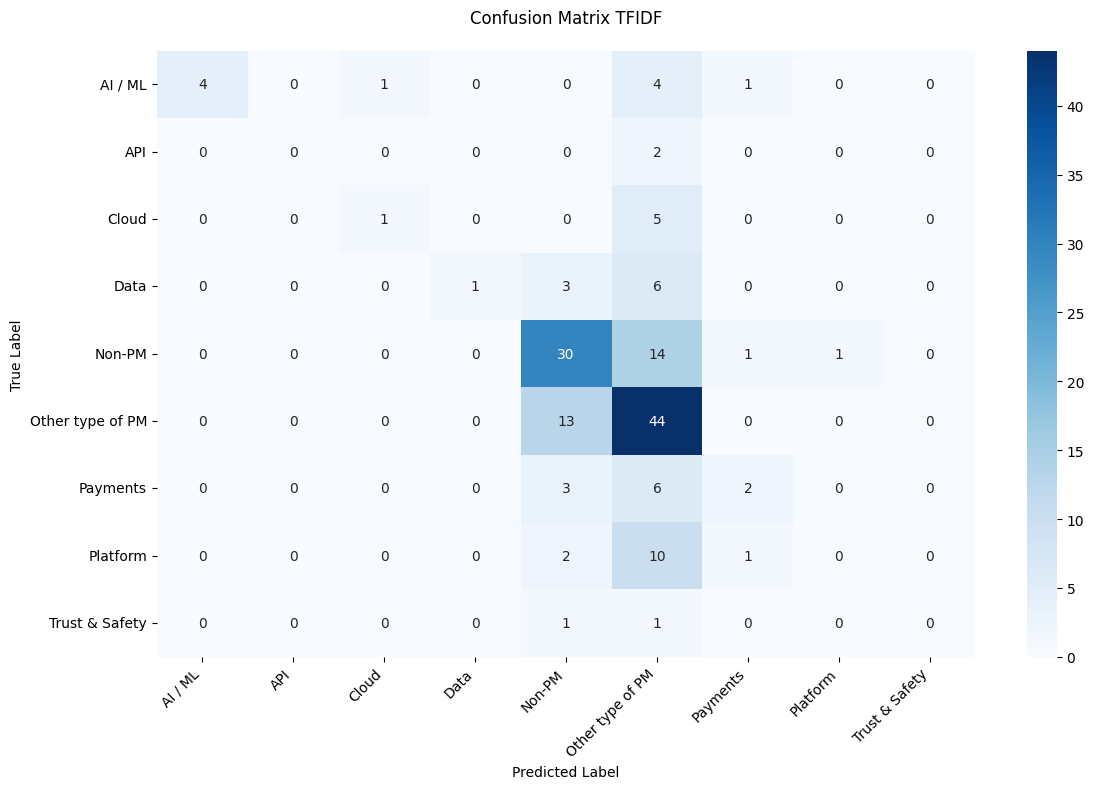

In [19]:
def plot_confusion_matrix_TFIDF(y_true, y_pred, label_map, figsize=(12, 8)):

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    title = 'Confusion Matrix TFIDF'

    # Get unique labels present in the data
    present_labels = sorted(set(y_true))
    label_names = [list(label_map.keys())[i] for i in present_labels]

    # Create figure and axes
    plt.figure(figsize=figsize)

    # Create heatmap
    sns.heatmap(cm,
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=label_names,
                yticklabels=label_names)

    # Customize the plot
    plt.title(title, pad=20)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # Rotate labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    return plt

plot = plot_confusion_matrix_TFIDF(y_val_tfidf, y_pred_tfidf, label_map)
plt.show()

### Model 3 - Sample Misclassfication

In [20]:
def display_misclassifications_TFIDF(predictions, true_labels, texts, label_map, target_pred='Other type of PM',
                             target_true_labels=['AI / ML', 'Non-PM']):
    """
    Display misclassifications where model predicted target_pred but was actually one of target_true_labels

    Args:
        predictions: array, model predictions
        true_labels: array, true labels
        texts: list, job titles + descriptions
        label_map: dict, mapping from label names to indices
        target_pred: str, target prediction label to analyze
        target_true_labels: list, target true labels to compare against
    """
    # Get label indices
    pred_idx = label_map[target_pred]
    true_indices = [label_map[label] for label in target_true_labels]

    print(f"\n=== TFIDF Model Misclassifications ===")

    # Find misclassifications for each target true label
    for true_label, true_idx in zip(target_true_labels, true_indices):
        misclassified = [(i, text) for i, (text, pred, true)
                        in enumerate(zip(texts, predictions, true_labels))
                        if pred == pred_idx and true == true_idx]

        if misclassified:
            i, text = misclassified[0]
            print(f"\nPredicted: {target_pred}")
            print(f"Actual: {true_label}")
            print("\nTitle + Description:")
            print(f"{text[:1000]}...")
            print("\n" + "-"*50)

# For TFIDF model
tfidf_val_texts = [texts[i] for i in range(len(texts)) if i in range(len(X_val_tfidf.toarray()))]
display_misclassifications_TFIDF(
    predictions=y_pred_tfidf,
    true_labels=y_val_tfidf,
    texts=tfidf_val_texts,
    label_map=label_map
)


=== TFIDF Model Misclassifications ===

Predicted: Other type of PM
Actual: AI / ML

Title + Description:
Senior Manager, Digital Product Management Company Summary:

DISH, an EchoStar company, has been reimagining the future of connectivity for more than 40 years. Our business reach spans satellite television service, live-streaming and on-demand programming, smart home installation services, mobile plans and products and now we are building America’s First Smart Network™.  

  

Today, our brands include EchoStar, Hughes, DISH TV, Sling TV, Boost Mobile and Gen Mobile.
Department Summary:

Our Technology teams challenge the status quo and reimagine capabilities across industries. Whether through research and development, technology innovation or solution engineering, our people play vital roles in connecting consumers with the products and platforms of tomorrow.
Job Duties and Responsibilities:

As we continue the roll-out of our 5G network, and navigate the changing landscape in te

## GPT4 Chain-of-Thought (CoT) Model

### Configuration:
- **Model**:
  - `GPT-4-turbo-preview`
- **Step-by-Step Reasoning**:
  - `Check if this is a PM role`
    - `If not, classify as Non-PM`
    - `If yes, next step`
  - `Check against specific category criteria`
  - `Output exactly one category from the allowed list`

### Results:
- **Data**: 211 selected samples
- **Accuracy**: 67.30%


In [ ]:
! pip install openai

In [ ]:
from typing import Dict, List, Optional
import json
import os
from datetime import datetime
import logging
from openai import OpenAI

In [ ]:
# Read data
df_GPT = df
# Filter rows from index 256 to 467
filtered_df = df_GPT.iloc[256:467]

# Initialize OpenAI client
client = OpenAI(api_key="YOURAPI")

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

def classify_job(job_description: str) -> dict:
    """Classify a single job description"""
    system_prompt = """
    You are a job classification expert. Your task is to classify product management job descriptions into specific categories.
    Follow this exact chain of thought:
    1. First, check if this is a PM role
    2. If not PM role, classify as "Non-PM"
    3. If PM role, analyze against specific category criteria
    4. Output exactly one category from the allowed list

    Output format must be JSON with two fields:
    {
        "reasoning": "Your step-by-step reasoning here",
        "category": "Exact category name"
    }

    Valid categories are:
    - AI/ML Product Manager
    - Platform Product Manager
    - Cloud Product Manager
    - Other Product Manager Types
    - Payments Product Manager
    - Data Product Manager
    - API / Integrations Product Manager
    - Trust & Safety Product Manager
    - Non-PM

    - AI/ML Product Manager: Look for titles that include AI, Artificial Intelligence, Machine Learning (ML), Deep Learning, GenAI, or related AI terms.
    - Platform Product Manager: Look for titles that mention Platform alongside Product Manager or similar terms suggesting responsibility for the underlying platform.
    - Cloud Product Manager: Label a post as Cloud Product Manager if the role description emphasizes managing cloud-based services, platforms, or infrastructure.
    - Other Product Manager Types: Label a post as Other type of Product Manager if it describes responsibilities focused on developing and enhancing critical product features, typically central to the user experience and product value.
    - Payments Product Manager: Look for titles that include Payments alongside Product Manager or terms related to payment processing or financial transactions.
    - Data Product Manager: Label a post as Data Product Manager if it describes responsibilities focused on managing data platforms, tools, and products that support data analytics, insights, and machine learning applications.
    - API / Integrations Product Manager: Label a post as API & Integrations Product Manager if it describes responsibilities focused on developing and managing APIs, creating integration capabilities, and optimizing partnerships with external or internal developers.
    - Trust & Safety Product Manager: Label a post as Trust & Safety Product Manager if it describes responsibilities focused on ensuring user safety, managing content policies, and enforcing compliance. K

    """

    try:
        messages = [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": f"Please classify this job description:\n\n{job_description}"}
        ]

        response = client.chat.completions.create(
            model="gpt-4-turbo-preview",
            messages=messages,
            temperature=0.1,
            response_format={"type": "json_object"}
        )

        return json.loads(response.choices[0].message.content)

    except Exception as e:
        logger.error(f"Error in classification: {str(e)}")
        return {
            "reasoning": f"Error occurred during classification: {str(e)}",
            "category": "Other Product Manager Types"
        }

# Process each job description
results = []
for index, row in filtered_df.iterrows():
    # Combine title and description for better context
    full_description = f"Title: {row['title']}\nCompany: {row['company']}\nDescription: {row['description']}"

    # Classify the job
    result = classify_job(full_description)

    # Add job details to result
    result['id'] = row['id']
    result['title'] = row['title']
    result['company'] = row['company']

    results.append(result)

    # Log progress
    logger.info(f"Processed job {index} - {row['id']} - Category: {result['category']}")

# Save results to JSON
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
output_filename = f'job_classifications_{timestamp}.json'

with open(output_filename, 'w') as f:
    json.dump(results, f, indent=2)

logger.info(f"Results saved to {output_filename}")

# Create a summary DataFrame
summary_df = pd.DataFrame(results)
print("\nClassification Summary:")
print(summary_df['category'].value_counts())

# Save to CSV as well
csv_filename = f'job_classifications_{timestamp}.csv'
summary_df.to_csv(csv_filename, index=False)
logger.info(f"Results also saved to {csv_filename}")

Load Pre-saved Results

In [ ]:
correct_label = 0
GPT4_label_results = pd.read_csv('/content/drive/MyDrive/INFO256/GPT4_label_211Sample.csv')
# Compare the first words
for i, row in GPT4_label_results.iterrows():
    if row['category_first'] == row['technology_first']:
        correct_label += 1

# Calculate and print the proportion
print(f"{(correct_label / len(GPT4_label_results) * 100):.2f}%")

67.30%


## Visualizations

### Accuracy by Model - Figure 1

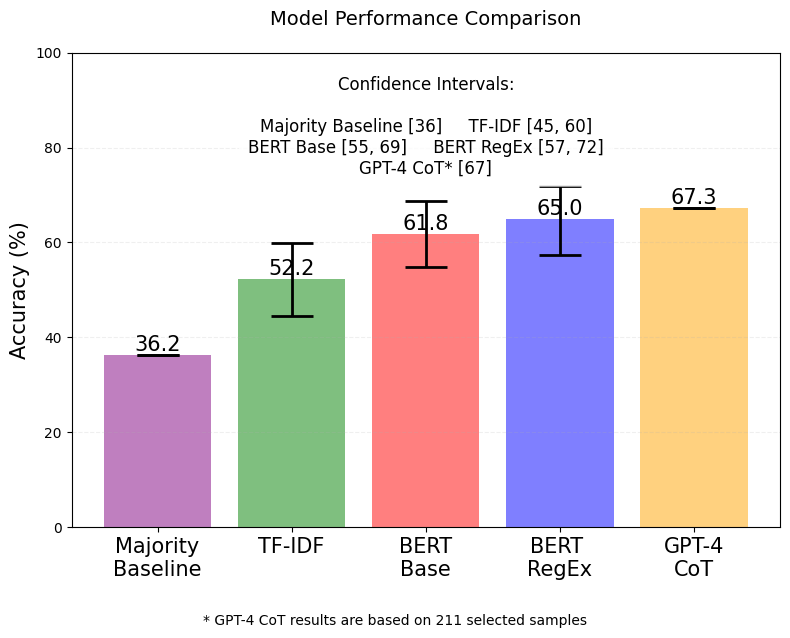

In [27]:
# Figure 1 - Model Performance Comparison
methods = ['Majority\nBaseline', 'TF-IDF', 'BERT\nBase', 'BERT \nRegEx', 'GPT-4\nCoT']
accuracies = [36.19, 52.23, 61.78, 64.97, 67.30]
ci_lower = [36.19, 44.59, 54.78, 57.32, 67.30]
ci_upper = [36.19, 59.87, 68.81, 71.97, 67.30]

# Calculate error bar lengths
yerr_lower = np.array(accuracies) - np.array(ci_lower)
yerr_upper = np.array(ci_upper) - np.array(accuracies)
yerr = np.array([yerr_lower, yerr_upper])

# Colors
colors = ['purple', 'green', 'red', 'blue', 'orange']
alpha = 0.5

# Create the plot
plt.figure(figsize=(8, 6))
bars = plt.bar(methods, accuracies, color=colors, alpha=alpha)

# Add error bars
plt.errorbar(methods, accuracies, yerr=yerr, fmt='none', color='black', capsize=15,
             capthick=2, elinewidth=2)

# Customize the plot
plt.ylabel('Accuracy (%)', fontsize=15)
plt.xticks(fontsize=15)
plt.grid(axis='y', linestyle='--', alpha=0.2)
plt.ylim(0, 100)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}',
             ha='center', va='bottom', fontsize=15)

# Create CI text for text box
ci_text = "Confidence Intervals:\n"
ci_text += "\n"
ci_text += f"Majority Baseline [{ci_lower[0]:.0f}]     "
ci_text += f"TF-IDF [{ci_lower[1]:.0f}, {ci_upper[1]:.0f}]\n"
ci_text += f"BERT Base [{ci_lower[2]:.0f}, {ci_upper[2]:.0f}]     "
ci_text += f"BERT RegEx [{ci_lower[3]:.0f}, {ci_upper[3]:.0f}]\n"
ci_text += f"GPT-4 CoT* [{ci_lower[4]:.0f}]"

# Add text box inside the plot
plt.text(0.5, 0.95, ci_text,
         horizontalalignment='center',
         verticalalignment='top',
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='white', boxstyle='round,pad=0.5'), fontsize=12)

# Add footnote about GPT-4 CoT sample size
footnote = "* GPT-4 CoT results are based on 211 selected samples"
plt.figtext(0.5, -0.05, footnote, ha='center', fontsize=10)

plt.title('Model Performance Comparison', fontsize=14, pad=20)


# Use tight_layout instead of subplots_adjustx
plt.tight_layout()

plt.show()

### F1Score by Category - Figure 2

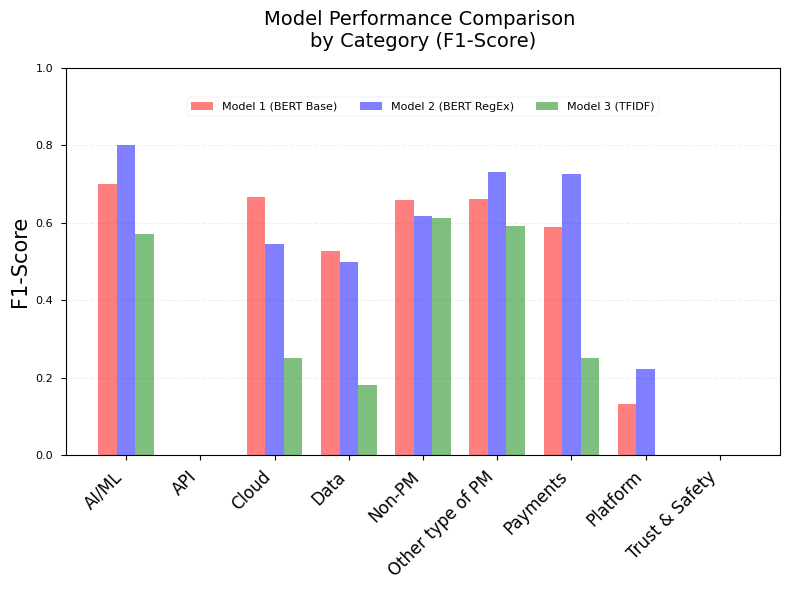

In [28]:
# Data preparation
categories = ['AI/ML', 'API', 'Cloud', 'Data', 'Non-PM', 'Other type of PM',
              'Payments', 'Platform', 'Trust & Safety']

f1_scores = {
    'Model 1 (BERT Base)': [0.700, 0.000, 0.667, 0.526, 0.660, 0.662, 0.588, 0.133, 0.000],
    'Model 2 (BERT RegEx)': [0.800, 0.000, 0.545, 0.500, 0.617, 0.732, 0.727, 0.222, 0.000],
    'Model 3 (TFIDF)': [0.571, 0.000, 0.250, 0.182, 0.612, 0.591, 0.250, 0.000, 0.000]
}

# Plot settings
plt.style.use('seaborn-v0_8-paper')
fig, ax = plt.subplots(figsize=(8, 6))

# Position calculations
x = np.arange(len(categories))
width = 0.25
multiplier = 0

# Color scheme suitable for academic publications
colors = ['red', 'blue', 'green']

# Plot bars for each model
for model, scores in f1_scores.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, scores, width, label=model, color=colors[multiplier], alpha = 0.5)
    multiplier += 1

# Customize the plot
ax.set_ylabel('F1-Score', fontsize=15)
ax.set_title('Model Performance Comparison \nby Category (F1-Score)',
            fontsize=14, pad=15)

# Customize x-axis
ax.set_xticks(x + width)
ax.set_xticklabels(categories, rotation=45, ha='right', fontsize=12)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.2)
ax.set_axisbelow(True)

# Customize legend
ax.legend(bbox_to_anchor=(0.5, 0.9), loc='center', ncol=3, frameon=True)

# Set y-axis limits
ax.set_ylim(0, 1.0)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

### Loss by Epoch - Figure 3

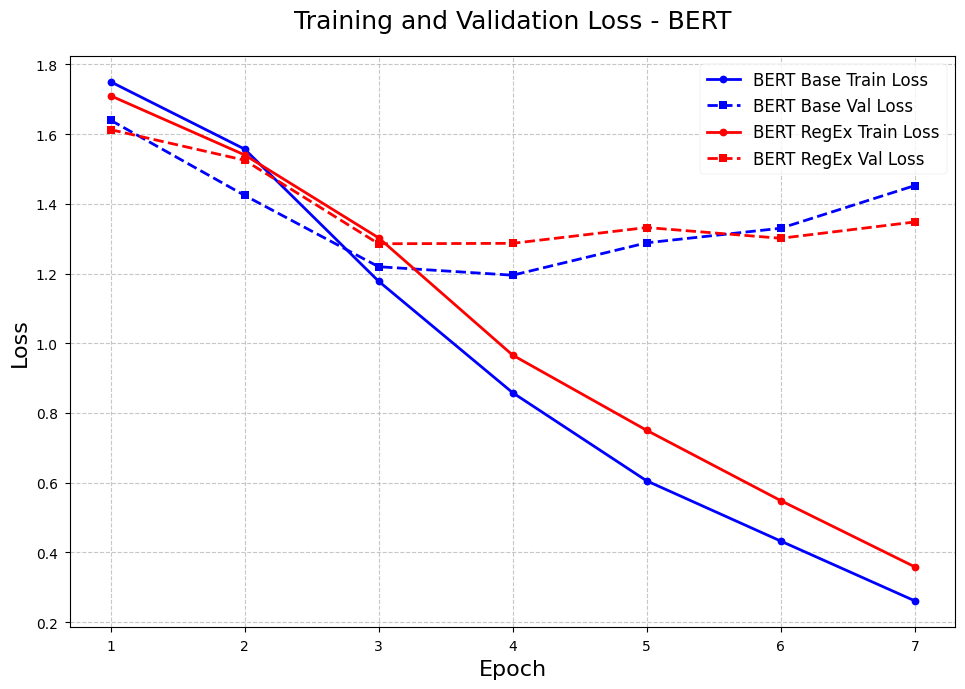

In [38]:
# Data for Model 1
model1_train_loss = [1.7502, 1.5570, 1.1779, 0.8581, 0.6052, 0.4325, 0.2610]
model1_val_loss = [1.6400, 1.4242, 1.2195, 1.1952, 1.2881, 1.3299, 1.4523]

# Data for Model 2
model2_train_loss = [1.7101, 1.5403, 1.3024, 0.9659, 0.7502, 0.5485, 0.3586]
model2_val_loss = [1.6128, 1.5251, 1.2854, 1.2866, 1.3320, 1.3011, 1.3479]

epochs = range(1, 8)

# Create the plot
plt.style.use('seaborn-v0_8-paper')
plt.figure(figsize=(12, 7))

# Plot Model 1
plt.plot(epochs, model1_train_loss, 'b-', label='BERT Base Train Loss', linewidth=2, marker='o')
plt.plot(epochs, model1_val_loss, 'b--', label='BERT Base Val Loss', linewidth=2, marker='s')

# Plot Model 2
plt.plot(epochs, model2_train_loss, 'r-', label='BERT RegEx Train Loss', linewidth=2, marker='o')
plt.plot(epochs, model2_val_loss, 'r--', label='BERT RegEx Val Loss', linewidth=2, marker='s')

# Customize the plot
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Training and Validation Loss - BERT', fontsize=18, pad=20)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(epochs, fontsize=10)
plt.yticks(fontsize=10)

# Add legend
plt.legend(fontsize=12, bbox_to_anchor=(1, 1))

# Adjust layout to prevent text cutoff
plt.tight_layout()
plt.subplots_adjust(right=0.8)

plt.show()

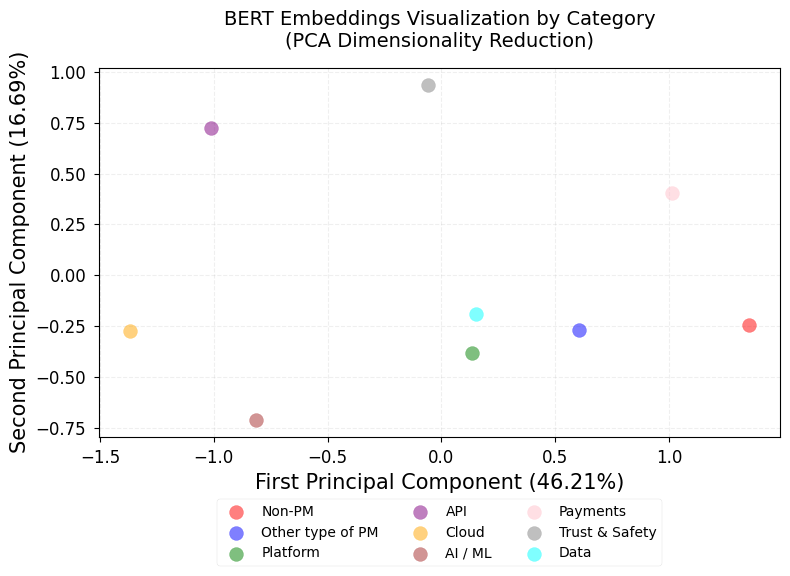

In [ ]:
# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def get_bert_embedding(text):
    """Get BERT embedding for a single text"""
    # Tokenize and encode
    encoding = tokenizer(
        text,
        padding='max_length',
        truncation=True,
        max_length=512,
        return_tensors='pt'
    )

    # Move to device
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Get BERT embedding
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        # Use CLS token embedding
        embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()

    return embedding[0]

# Create a dictionary to store texts by category
category_texts = {}
for label, title, desc in zip(labels, titles, extract_tokens):
    category = list(label_map.keys())[label]
    if category not in category_texts:
        category_texts[category] = []
    category_texts[category].append(f"{title} {desc}")

# Get average embedding for each category
category_embeddings = {}
print("Processing categories...")
for category, texts in category_texts.items():
    print(f"Processing {category}...")
    embeddings = []
    for text in texts:
        embedding = get_bert_embedding(text)
        embeddings.append(embedding)
    # Calculate average embedding for the category
    category_embeddings[category] = np.mean(embeddings, axis=0)

# Convert embeddings to array for PCA
categories = list(category_embeddings.keys())
embeddings_array = np.array([category_embeddings[cat] for cat in categories])

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_array)

# Plotting with the specified style
plt.style.use('seaborn-v0_8-paper')
fig, ax = plt.subplots(figsize=(8, 6))

# Create scatter plot
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'cyan']
for i, (category, color) in enumerate(zip(categories, colors)):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1],
               c=[color],
               label=category,
               s=100,
               alpha=0.5)

# Customize the plot
ax.set_ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.2%})', fontsize=15)
ax.set_xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.2%})', fontsize=15)
ax.set_title('BERT Embeddings Visualization by Category\n(PCA Dimensionality Reduction)',
            fontsize=14, pad=15)

# Customize ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add grid for better readability
plt.grid(axis='both', linestyle='--', alpha=0.2)
ax.set_axisbelow(True)

# Customize legend
ax.legend(bbox_to_anchor=(0.5, -0.15),
         ncol=3,
         loc='upper center',
         frameon=True,
         fontsize=10)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()



In [ ]:
# Calculate pairwise distances
distances = cosine_distances(embeddings_array)

# Create list of all pairs and their distances
distance_pairs = []
for i, cat1 in enumerate(categories):
    for j, cat2 in enumerate(categories):
        if i < j:  # Only upper triangle
            distance_pairs.append((cat1, cat2, distances[i][j]))

# Sort by distance (descending) and get top 5
top_5_pairs = sorted(distance_pairs, key=lambda x: x[2], reverse=True)[:5]
lower_5_pairs = sorted(distance_pairs, key=lambda x: x[2])[:5]

print("\nTop 5 highest pairwise distances:")
for cat1, cat2, dist in top_5_pairs:
    print(f"{cat1} vs {cat2}: {dist:.3f}")
print("\nTop 5 closest pairwise distances:")
for cat1, cat2, dist in lower_5_pairs:
    print(f"{cat1} vs {cat2}: {dist:.3f}")


Top 5 highest pairwise distances:
Non-PM vs Cloud: 0.017
Cloud vs Payments: 0.015
Non-PM vs API: 0.015
Non-PM vs AI / ML: 0.013
AI / ML vs Payments: 0.012

Top 5 closest pairwise distances:
Other type of PM vs Data: 0.002
Non-PM vs Other type of PM: 0.002
Other type of PM vs Platform: 0.004
Platform vs Data: 0.004
Other type of PM vs Payments: 0.004
